In [152]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [153]:
resolution = '10km'
n_clusters = 7
train_file = f'data/{resolution}_data.csv'
truth_file = f'data/{resolution}_truth.csv'

train_data = pd.read_csv(train_file)
Xraw = np.array(train_data[['lat', 'long']])
Yraw = np.array(train_data['generated_temp']).reshape(-1,1)
print(Xraw.shape, Yraw.shape)

truth = pd.read_csv(truth_file)
true_alt, true_temp = get_alt_temp_grids(truth, ocean=False)

(12700, 2) (12700, 1)


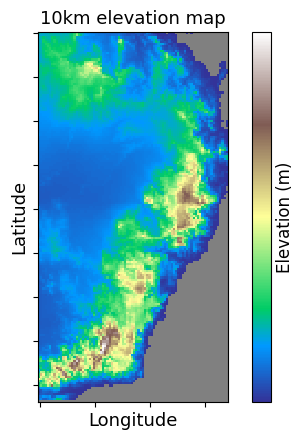

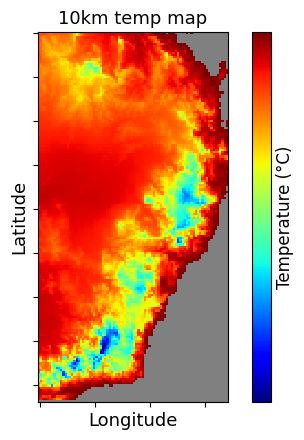

In [154]:
# PLOT TEMP AND ELEVATION FOR RAW DATAFRAME
plot_area(true_alt, 'elevation', title=f'{resolution} elevation map', grey_back=True)

plot_area(true_temp, 'temperature', title=f'{resolution} temp map', grey_back=True, color='jet')

In [155]:
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [156]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 128,
                    'n_epochs'    : 2500,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 2e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : n_clusters},
                         'verbose' : 0
}

In [157]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run/experiment0030
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2500
75/75 [==============================] - 1s 4ms/step - loss: 1.9552 - val_loss: 1.7135
Epoch 2/2500
75/75 [==============================] - 0s 2ms/step - loss: 1.5975 - val_loss: 1.4207
Epoch 3/2500
75/75 [==============================] - 0s 2ms/step - loss: 1.3489 - val_loss: 1.2218
Epoch 4/2500
75/75 [==============================] - 0s 2ms/step - loss: 1.1840 - val_loss: 1.0940
Epoch 5/2500
75/75 [==============================] - 0s 2ms/step - loss: 1.0792 - val_loss: 1.0148
Epoch 6/2500
75/75 [==============================] - 0s 2ms/step - loss: 1.0156 - val_loss: 0.9672
Epoch 7/2500
75/75 [==============================] - 0s 2ms/step - loss: 0.9773 - val_loss: 0.9385
Epoch 8/2500
75/75 [==============================] - 0s 2ms/step - loss: 0.9537 - val_loss: 0.9202
Epoch 9/2500
75/75 [==============================] - 0s

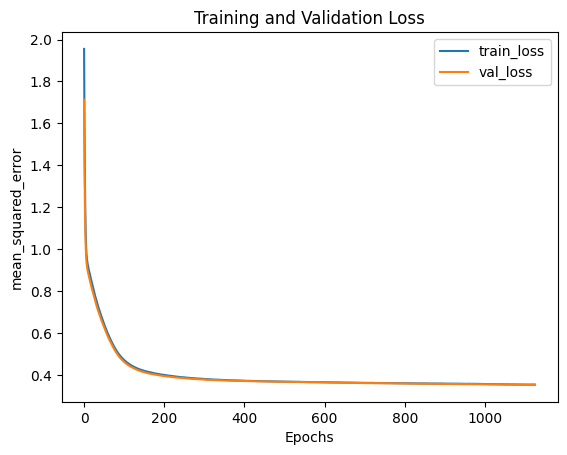

397/397 [==============================] - 0s 951us/step
Loading parameters from  tmp_checkpoints29042025230855/best_weights
Saving parameters to  sample_run/experiment0030/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [158]:
results = my_exp.train()

# Reconstruct the elevation map based on labels

# LOOK IN DATA, POINTS ARE GROUPED BY LAT

In [159]:
xlbls = results['CauseClusterer']['x_lbls']

print(len(xlbls))
print(len(set(xlbls)))

12700
7


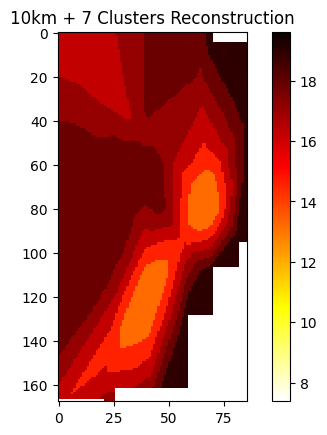

In [160]:
reconstruct_temps = reconstruct_plot(train_data, xlbls, title=f'{resolution} + {n_clusters} Clusters Reconstruction')

In [161]:
'''import pickle

file = 'saved_runs/10km2_experiment2/dataset_train/CauseClusterer_results.pickle'
with open(file, 'rb') as f:
    results = pickle.load(f)
xlbls = results['x_lbls']'''

"import pickle\n\nfile = 'saved_runs/10km2_experiment2/dataset_train/CauseClusterer_results.pickle'\nwith open(file, 'rb') as f:\n    results = pickle.load(f)\nxlbls = results['x_lbls']"

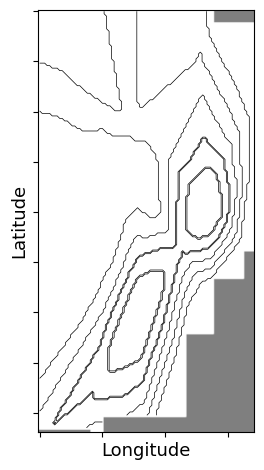

In [162]:
contour_grid = reconstruct_contour(train_data, xlbls, n_clusters, title=None, grey_back=True)